In [78]:
import matplotlib.pyplot as plt
import numpy as np
import os, sys, time
import numpy.random as rn
import torch
import matplotlib.patches as mpatches

In [79]:
# Step 1: Create multivariate gaussians and visual
#numpy.random.multivariate_normal(mean, cov[, size, check_valid, tol
dim=2 # data dimension
seed=512
nsamples=50000 # total number of samples
ntrain=4000
var=0.05 #0.1
ntasks=4
batch_size=20
alpha=0.25 #0.25,0.5,0.75
learning_rate =0.3*1e-5
hidden_units = 10
gradient_steps = 1
dev = 'cpu' #'cuda'
icon=['bx','ro','g*','c<']
use_hard_buffer=True
loss_window_mean_threshold=0.15
loss_window_variance_threshold=5*10**-5
continual_learning=True
MAS_weight=0.5
loss_window_length=10


tasks={}
inputs={}
labels={}
test_inputs={}
test_labels={}

        

In [133]:
def sample_data():
    global tasks, inputs, labels, test_inputs, test_labels
    verbose=False
    # seed
    rn.seed(512)
    uniform_width=1.25
    offset=0.05
    tasks={}
    stime=time.time()
    # sample points for four tasks related to four quadrants
    for q in range(ntasks):
        #print("quadrant {0}".format(q))
        # step 1 sample points in quadrant uniformly from [0:1]
        if q == 0: # 1th quadrant
            xs=rn.uniform(offset,uniform_width,nsamples)
            ys=rn.uniform(offset,uniform_width,nsamples)
        elif q == 1: # 2nd quadrant
            xs=rn.uniform(-offset,-uniform_width,nsamples)
            ys=rn.uniform(offset,uniform_width,nsamples)
        elif q == 2: # 3th quadrant
            xs=rn.uniform(-offset,-uniform_width,nsamples)
            ys=rn.uniform(-offset,-uniform_width,nsamples)
        else: #4th quadrant
            xs=rn.uniform(offset,uniform_width,nsamples)
            ys=rn.uniform(-offset,-uniform_width,nsamples)
        samples=[]
        for i in range(len(xs)):
            sample=[xs[i],ys[i]]
            for j in range(dim-2): #add noise gausians in other dimensions
                sample.append(rn.normal(0,var))
            samples.append(sample)
        tasks[q]=np.asarray(samples)
        #tasks[q]=np.asarray([[xs[i],ys[i]] for i in range(len(xs))])
        if verbose: plt.plot(xs,ys,icon[q%ntasks])
    if verbose: plt.show()
    #print "step 1: ",time.time()-stime

    stime=time.time()
    # if verbose: plt.show()

    inputs={}
    labels={}
    # Step 3: Sample correct distribution given certain alpha
    for q in range(ntasks):
        original_task=rn.binomial(np.ones((ntrain),dtype=np.int),alpha) #1 if original task, 0 if data sampled from 1 of the others.
        inputs[q]=[]
        labels[q]=[]
        other_quadrants=range(ntasks)
        del other_quadrants[q]
        for v in original_task:
            if v: #pick from correct quadrant
                q_temp=q
            else: # pick from random other quadrant
                q_temp=rn.choice(other_quadrants)
            sample=tasks[q_temp][0]
            inputs[q].append(sample) 
            # samples are popped from the distribution to avoid them to be reused.
            tasks[q_temp]=tasks[q_temp][1:]
            if np.sqrt(sample[0]**2+sample[1]**2)>1:
                label=0
            else:
                label=1
            labels[q].append(label)
            if verbose: plt.plot(sample[0],sample[1],icon[q])
    if verbose: plt.show()

    #print "step 2: ",time.time()-stime
    stime=time.time()

    # draw some extra test data to evaluate
    for q in range(ntasks):
        test_inputs[q]=tasks[q][:200]
    # label points according to distance to center
    test_labels={}
    for q in range(ntasks):
        test_labels[q]=[]
        for sample in test_inputs[q]:
            if np.sqrt(sample[0]**2+sample[1]**2) > 1:
                test_labels[q].append(0)
            else:
                test_labels[q].append(1)
    for q in range(ntasks):
        positive_points=[test_inputs[q][i] for i in range(len(test_inputs[q])) if test_labels[q][i]==1]
        negative_points=[test_inputs[q][i] for i in range(len(test_inputs[q])) if test_labels[q][i]==0]
        #print len(positive_points)
        #print len(negative_points)

        if verbose: plt.scatter([p[0] for p in positive_points],[p[1] for p in positive_points],color='blue')
        if verbose: plt.scatter([p[0] for p in negative_points],[p[1] for p in negative_points],color='red')
    if verbose: plt.show()
    #print "step 3: ",time.time()-stime

In [139]:
# Step 4: Define network
def experiment(use_hard_buffer=False,continual_learning=False,recent_buffer_size=30,hard_buffer_size=30):
    count_updates=0
    torch.manual_seed(seed)
    device = torch.device(dev)
    model = torch.nn.Sequential(
              torch.nn.Linear(dim, hidden_units, bias=True),
              torch.nn.ReLU(),
              torch.nn.Linear(hidden_units, hidden_units, bias=True),
              torch.nn.ReLU(),
              torch.nn.Linear(hidden_units, 2, bias=False),
    ).to(device)

    loss_fn = torch.nn.MSELoss(reduction='none')
    #loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
    optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
    #optimizer=torch.optim.Adadelta(model.parameters(), lr=learning_rate)
    # Reinitialize model
    for p in model.parameters():
        torch.nn.init.normal_(p, 0, 0.1)
    # Step 5: Define online loop through data + evaluation + visualization
    # Step 6: Define hard buffer
    # Step 7: Detect loss saturation
    # Step 8: >>Calculate importance weights<<
    # Step 9: Add regularizer
    stime=time.time()
    verbose=False
    losses=[]
    test_loss={i:[] for i in range(ntasks)}
    recent_buffer=[]
    hard_buffer=[]
    # loss dectection
    loss_window=[]
    loss_window_means=[]
    loss_window_variances=[]
    update_tags=[]
    new_peak_detected=True
    # MAS regularization: list of 3 weights vectors as there are 3 layers.
    star_variables=[]
    omegas=[] #initialize with 0 importance weights
    for t in range(ntasks):
        for s in range(len(inputs[t])):
            # plt.scatter(inputs[t][s][0],inputs[t][s][1],color='red' if labels[t][s]==0 else 'blue')
            # save experience in replaybuffer
            recent_buffer.append({'state':inputs[t][s],
                                 'trgt':labels[t][s]})
            if len(recent_buffer) > recent_buffer_size:
                del recent_buffer[0]
            
            # Train model on replaybuffer when it is full:
            if len(recent_buffer) == recent_buffer_size:
                msg='task: {0} step: {1}'.format(t,s)
                x=[_['state'] for _ in recent_buffer]
                y=[_['trgt'] for _ in recent_buffer]
                if use_hard_buffer:
                    x.extend([_['state'] for _ in hard_buffer])
                    y.extend([_['trgt'] for _ in hard_buffer])

                for gs in range(gradient_steps):
                    y_pred = model(torch.from_numpy(np.asarray(x).reshape(-1,dim)).type(torch.float32))
                    y_sup=torch.zeros(len(y),2).scatter_(1,torch.from_numpy(np.asarray(y).reshape(-1,1)).type(torch.LongTensor),1.).type(torch.FloatTensor)
                    #y_sup=torch.from_numpy(np.asarray(y)).type(torch.LongTensor)
                    train_loss = loss_fn(y_pred,y_sup)
                    total_loss = loss_fn(y_pred,y_sup)
                    
                    # add MAS regularization to train loss...
                    if continual_learning and len(star_variables)!=0 and len(omegas)!=0:
                        for pindex, p in enumerate(model.parameters()):
                            total_loss+=MAS_weight/2*torch.sum(torch.from_numpy(omegas[pindex]).type(torch.float32)*(p-star_variables[pindex])**2)
                    # train
                    optimizer.zero_grad()
                    #model.zero_grad()
#                    train_loss.backward()
                    torch.sum(total_loss).backward()
                    #with torch.no_grad():
                    #    for param in model.parameters(): param.data -= learning_rate * param.grad
                    optimizer.step()
                
                # save training accuracy
                y_pred = model(torch.from_numpy(np.asarray(x).reshape(-1,dim)).type(torch.float32))
                accuracy = np.mean(np.argmax(y_pred.detach().numpy(),axis=1)==y)
                loss=train_loss.detach().numpy()
                msg+=' train: {0:0.3f}'.format(np.mean(loss))
                losses.append(np.mean(accuracy))
                
                # empty recent buffer after training couple of times
                recent_buffer = []
            
                # add loss to loss_window and detect importance weight update
                loss_window.append(np.mean(loss))
                if len(loss_window)>loss_window_length: del loss_window[0]
                loss_window_mean=np.mean(loss_window)
                loss_window_variance=np.var(loss_window)
                if not new_peak_detected and loss_window_mean > last_loss_window_mean+last_loss_window_variance:
                    new_peak_detected=True
                if continual_learning and loss_window_mean < loss_window_mean_threshold and loss_window_variance < loss_window_variance_threshold and new_peak_detected:
                    #print("Update importance weights")
                    count_updates+=1
                    update_tags.append(0.01)
                    last_loss_window_mean=loss_window_mean
                    last_loss_window_variance=loss_window_variance
                    new_peak_detected=False
                    # calculate importance weights and update star_variables
                    model.zero_grad()
                    y_pred=model(torch.from_numpy(np.asarray(x).reshape(-1,dim)).type(torch.float32))
                    torch.sum(y_pred).backward()
                    omegas_old = omegas[:]
                    omegas=[]
                    star_variables=[]
                    for pindex, p in enumerate(model.parameters()):
                        if len(omegas_old) != 0:
                            omegas.append((np.abs(p.grad.data.clone().detach().numpy())+omegas_old[pindex])/2)
                        else:
                            omegas.append(np.abs(p.grad.data.clone().detach().numpy()))
                        star_variables.append(p.data.clone().detach())
                else:
                    update_tags.append(0)
                loss_window_means.append(loss_window_mean)
                loss_window_variances.append(loss_window_variance)

                #update hard_buffer
                if use_hard_buffer:
                    hard_buffer=[]
                    loss=np.mean(loss,axis=1)
                    try:
                        sorted_inputs=[np.asarray(lx) for _,lx in reversed(sorted(zip(loss.tolist(),x),key= lambda f:f[0]))]
                        sorted_targets=[ly for _,ly in reversed(sorted(zip(loss.tolist(),y),key= lambda f:f[0]))]
                    except:
                        import pdb; pdb.set_trace()
                    for i in range(min(hard_buffer_size,len(sorted_inputs))):
                        hard_buffer.append({'state':sorted_inputs[i],
                                           'trgt':sorted_targets[i]})

                #evaluate on test set
                for i in range(ntasks):
                    y_pred=model(torch.from_numpy(test_inputs[i].reshape(-1,dim)).type(torch.float32))
                    y_sup=torch.zeros(len(test_inputs[i]),2).scatter_(1,torch.from_numpy(np.asarray(test_labels[i]).reshape(-1,1)),1.).type(torch.FloatTensor)
                    #loss=loss_fn(y_pred,y_sup).detach().numpy()
                    test_loss[i].append(np.mean(np.argmax(y_pred.detach().numpy(),axis=1)==test_labels[i]))
                    msg+=' test[{0}]: {1:0.3f}'.format(i,np.mean(loss))
                if verbose:
                    print(msg)
    if False:
        for q in range(ntasks):
            y_pred=model(torch.from_numpy(test_inputs[q].reshape(-1,dim)).type(torch.float32)).detach().numpy()
            positive_points=[test_inputs[q][i] for i in range(len(test_inputs[q])) if np.argmax(y_pred[i])==1]
            negative_points=[test_inputs[q][i] for i in range(len(test_inputs[q])) if np.argmax(y_pred[i])==0]
            plt.scatter([p[0] for p in positive_points],[p[1] for p in positive_points],color='blue')
            plt.scatter([p[0] for p in negative_points],[p[1] for p in negative_points],color='red')
        plt.show()
    
    print("duration: {0}minutes, count updates: {1}".format((time.time()-stime)/60., count_updates))
    return losses, loss_window_means, update_tags, loss_window_variances, test_loss
#     return losses, test_loss



In [116]:
def meta_experiment(tags=['Online Continual','Online Continual No Hardbuffer','Online','Online No Hardbuffer']):
    print("\n\n\n\nStart experiment with alpha: {0}".format(alpha))
    sample_data()

    training_losses={}
    test_losses={}

    #tags=['Online Continual','Online Continual No Hardbuffer','Online','Online No Hardbuffer']
    settings={'Online Continual':(True, True,batch_size/2,batch_size/2),
             'Online Continual No Hardbuffer':(False, True,batch_size,0),
             'Online':(True, False,batch_size/2,batch_size/2),
             'Online No Hardbuffer':(False, False,batch_size,0)}
    colors={'Online Continual':'C2',
             'Online Continual No Hardbuffer':'C3',
             'Online':'C4',
             'Online No Hardbuffer':'C5'}



    for tag in tags:
        print("\n{0}".format(tag))
        # losses, loss_window_means, update_tags, loss_window_variances, test_loss=experiment(use_hard_buffer,continual_learning)
        training_losses[tag], loss_window_means, update_tags, loss_window_variances, test_losses[tag]=experiment(settings[tag][0],settings[tag][1],settings[tag][2],settings[tag][3])

    # Plot training loss
    if True:
        legend=[]
        plt.title('training accuracy')
        #for i in range(ntasks): plt.axvline(x=(i+1)*ntrain,color='gray')
        for tag in tags:    
            plt.plot(training_losses[tag],color=colors[tag])
            legend.append(mpatches.Patch(color=colors[tag], label=tag))
        plt.legend(handles=legend)
        plt.show()
        subsample=1
    # Plot test loss
    if True:
#        for task in range(ntasks):
        for task in range(1):
            legend=[]
            plt.title('test loss task {0}'.format(task))
            plt.ylim((0,1))
            #for i in range(ntasks): plt.axvline(x=(i+1)*ntrain,color='gray')
            for tag in tags:  
                plt.plot(np.arange(0,len(test_losses[tag][task]),subsample),test_losses[tag][task][::subsample],color=colors[tag])
                legend.append(mpatches.Patch(color=colors[tag], label=tag))
            plt.legend(handles=legend)
            plt.show()

    # Get final average accuracy for each tag:
    for tag in tags:
        print "{0}: {1}".format(tag,np.mean([test_losses[tag][task][-1]*100 for task in range(ntasks)]))
    return [np.mean([test_losses[tag][task][-1]*100 for task in range(ntasks)]) for tag in sorted(tags)]

In [ ]:
dim=50
var=1 #0.1 #variance of noise over uninformative dimensions

learning_rate=0.0006
ntrain=10000
batch_size=20
hidden_units = 10
gradient_steps = 5

seed=512
ntasks=3
loss_window_length=10
loss_window_mean_threshold=0.15
loss_window_variance_threshold=5*10**-5
MAS_weight=0.5

#tags=['Online Continual','Online Continual No Hardbuffer','Online','Online No Hardbuffer']
tags=['Online']


start_exp=time.time()
alpha=1.0
meta_experiment(tags)
print "duration: "+str(time.time()-start_exp)
start_exp=time.time()
alpha=0.75
meta_experiment(tags)
print "duration: "+str(time.time()-start_exp)
start_exp=time.time()
alpha=0.5
meta_experiment(tags)
print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 0.5

Online No Hardbuffer
duration: 0.1569993337minutes, count updates: 0


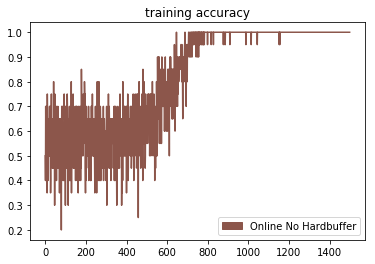

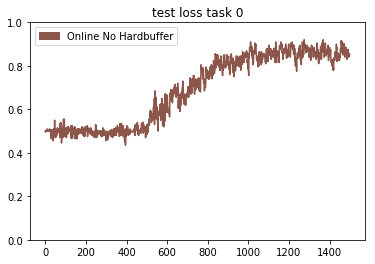

Online No Hardbuffer: 87.0
duration: 29.4219379425


In [145]:
dim=20
var=2 #0.1 #variance of noise over uninformative dimensions

learning_rate=0.001
ntrain=10000
batch_size=20
hidden_units = 10
gradient_steps = 5

seed=512
ntasks=3
loss_window_length=10
loss_window_mean_threshold=0.15
loss_window_variance_threshold=5*10**-5
MAS_weight=0.5

#tags=['Online Continual','Online Continual No Hardbuffer','Online','Online No Hardbuffer']
tags=['Online No Hardbuffer']


start_exp=time.time()
alpha=.5
meta_experiment(tags)
print "duration: "+str(time.time()-start_exp)
#start_exp=time.time()
#alpha=0.75
#meta_experiment(tags)
#print "duration: "+str(time.time()-start_exp)
#start_exp=time.time()
#alpha=0.5
#meta_experiment(tags)
#print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 1.0

Online Continual
duration: 2.19031113386minutes, count updates: 25

Online Continual No Hardbuffer
duration: 0.692833264669minutes, count updates: 1

Online
duration: 0.971847399076minutes, count updates: 0

Online No Hardbuffer
duration: 0.472683131695minutes, count updates: 0


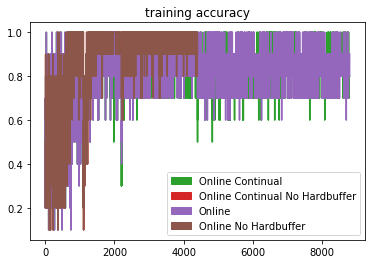

Online Continual: 95.875
Online Continual No Hardbuffer: 90.75
Online: 90.625
Online No Hardbuffer: 87.875
duration: 261.765405893




Start experiment with alpha: 0.9

Online Continual
duration: 1.96769885222minutes, count updates: 14

Online Continual No Hardbuffer
duration: 0.627044049899minutes, count updates: 0

Online
duration: 1.02283536593minutes, count updates: 0

Online No Hardbuffer
duration: 0.491951950391minutes, count updates: 0


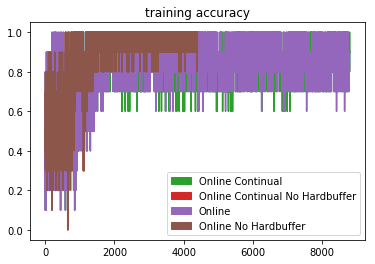

Online Continual: 92.875
Online Continual No Hardbuffer: 94.0
Online: 92.125
Online No Hardbuffer: 94.0
duration: 248.776473045




Start experiment with alpha: 0.8

Online Continual
duration: 1.67901895046minutes, count updates: 20

Online Continual No Hardbuffer
duration: 0.633694303036minutes, count updates: 1

Online
duration: 1.17198539972minutes, count updates: 0

Online No Hardbuffer
duration: 0.662657217185minutes, count updates: 0


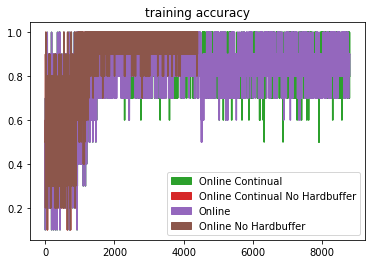

Online Continual: 93.125
Online Continual No Hardbuffer: 96.0
Online: 94.375
Online No Hardbuffer: 95.625
duration: 251.528839111




Start experiment with alpha: 0.7

Online Continual


KeyboardInterrupt: 

In [90]:
# total set of experiments, estimated time: 20minutes
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 10
gradient_steps = 5
seed=512
ntasks=4
loss_window_length=10
loss_window_mean_threshold=0.15
loss_window_variance_threshold=5*10**-5
continual_learning=True
MAS_weight=0.5

start_exp=time.time()
alpha=1.0
meta_experiment()
print "duration: "+str(time.time()-start_exp)
start_exp=time.time()
alpha=0.9
meta_experiment()
print "duration: "+str(time.time()-start_exp)
start_exp=time.time()
alpha=0.8
meta_experiment()
print "duration: "+str(time.time()-start_exp)
start_exp=time.time()
alpha=0.7
meta_experiment()
print "duration: "+str(time.time()-start_exp)
alpha=0.5
meta_experiment()
print "duration: "+str(time.time()-start_exp)
alpha=0.25
meta_experiment()
print "duration: "+str(time.time()-start_exp)

In [84]:
# total set of experiments, estimated time: 20minutes
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 10
gradient_steps = 5
seed=512
ntasks=4
loss_window_length=10
loss_window_mean_threshold=0.15
loss_window_variance_threshold=5*10**-5
continual_learning=True
MAS_weight=0.5

start_exp=time.time()
alpha=0.5
meta_experiment()
print "duration: "+str(time.time()-start_exp)
start_exp=time.time()
alpha=0.25
meta_experiment()
print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 0.5

Online Continual
duration: 1.81288706462minutes

Online Continual No Hardbuffer
duration: 0.483885582288minutes

Online
duration: 1.16166514953minutes

Online No Hardbuffer
duration: 0.536086666584minutes
Online Continual: 96.75
Online Continual No Hardbuffer: 90.75
Online: 95.25
Online No Hardbuffer: 90.75
duration: 242.185775042




Start experiment with alpha: 0.25

Online Continual
duration: 1.89319343567minutes

Online Continual No Hardbuffer
duration: 0.604311382771minutes

Online
duration: 1.42261894941minutes

Online No Hardbuffer
duration: 0.587824332714minutes
Online Continual: 90.25
Online Continual No Hardbuffer: 92.625
Online: 93.75
Online No Hardbuffer: 92.625
duration: 272.621608973


In [83]:
# total set of experiments, estimated time: 20minutes
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 10
gradient_steps = 5
seed=512
ntasks=4
loss_window_length=10
loss_window_mean_threshold=0.15
loss_window_variance_threshold=5*10**-5
continual_learning=True
MAS_weight=0.5

start_exp=time.time()
alpha=1.0
meta_experiment()
print "duration: "+str(time.time()-start_exp)
start_exp=time.time()
alpha=0.9
meta_experiment()
print "duration: "+str(time.time()-start_exp)
start_exp=time.time()
alpha=0.8
meta_experiment()
print "duration: "+str(time.time()-start_exp)
start_exp=time.time()
alpha=0.7
meta_experiment()
print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 1.0

Online Continual
duration: 1.71087646484minutes

Online Continual No Hardbuffer
duration: 0.648346265157minutes

Online
duration: 1.00775218407minutes

Online No Hardbuffer
duration: 0.520392334461minutes
Online Continual: 90.375
Online Continual No Hardbuffer: 83.75
Online: 85.0
Online No Hardbuffer: 80.875
duration: 234.277907133




Start experiment with alpha: 0.9

Online Continual
duration: 1.63866571585minutes

Online Continual No Hardbuffer
duration: 0.488980066776minutes

Online
duration: 1.02931704919minutes

Online No Hardbuffer
duration: 0.520264581839minutes
Online Continual: 94.5
Online Continual No Hardbuffer: 95.375
Online: 91.75
Online No Hardbuffer: 95.375
duration: 221.873847961




Start experiment with alpha: 0.8

Online Continual
duration: 1.38627827962minutes

Online Continual No Hardbuffer
duration: 0.436142317454minutes

Online
duration: 0.96823195219minutes

Online No Hardbuffer
duration: 0.459879601002minutes
Online Contin





Start experiment with alpha: 1.0
quadrant 0
quadrant 1
quadrant 2
quadrant 3
step 1:  0.745089054108
step 2:  0.521153211594
step 3:  0.0101759433746

Online Continual
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weig

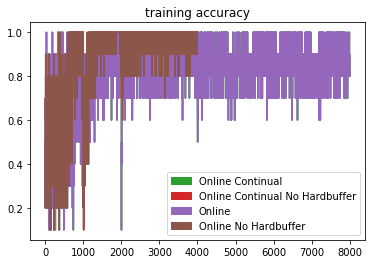

Online Continual: 85.0
Online Continual No Hardbuffer: 80.875
Online: 85.0
Online No Hardbuffer: 80.875
duration: 233.611252069


In [72]:
# lambda 0.5 -> 1. and loss_window_length 10 -> 50
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 10
gradient_steps = 5
seed=512
alpha=1.0
ntasks=4
loss_window_length=50
loss_window_mean_threshold=0.15
loss_window_variance_threshold=5*10**-5
continual_learning=True
MAS_weight=1

start_exp=time.time()
meta_experiment()

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 1.0
quadrant 0
quadrant 1
quadrant 2
quadrant 3
step 1:  0.551609992981
step 2:  0.674543142319
step 3:  0.0183930397034

Online Continual
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weig

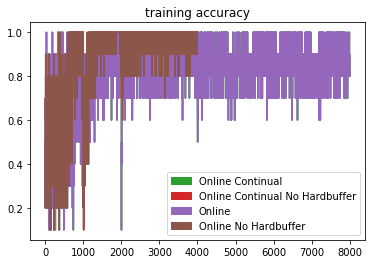

Online Continual: 85.0
Online Continual No Hardbuffer: 80.875
Online: 85.0
Online No Hardbuffer: 80.875
duration: 208.101047039


In [69]:
# lambda 0.5 -> 1.
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 10
gradient_steps = 5
seed=512
alpha=1.0
ntasks=4
loss_window_length=10
loss_window_mean_threshold=0.15
loss_window_variance_threshold=5*10**-5
continual_learning=True
MAS_weight=1

start_exp=time.time()
meta_experiment()

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 1.0
quadrant 0
quadrant 1
quadrant 2
quadrant 3
step 1:  0.597409009933
step 2:  0.602843999863
step 3:  0.264185905457

Online Continual
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weigh

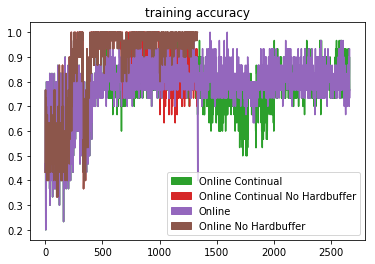

Online Continual: 85.25
Online Continual No Hardbuffer: 79.5
Online: 86.375
Online No Hardbuffer: 79.125
duration: 88.8589458466


In [67]:
# ALPHA 1 BATCHSIZE 30
learning_rate=0.0009
ntrain=10000
batch_size=30
hidden_units = 10
gradient_steps = 5
seed=512
alpha=1.0
ntasks=4
start_exp=time.time()
meta_experiment()

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 1.0
quadrant 0
quadrant 1
quadrant 2
quadrant 3
step 1:  0.595020055771
step 2:  0.451049089432
step 3:  0.00874710083008

Online Continual
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
duration: 1.58722044627minutes

Online Continual No Hardbuffer
Update importance weights
Update importance weights
duration: 0.586535016696minutes

Online
duration: 1.0988192002minutes

Online No Hardbuffer
duration: 0.526490330696minutes


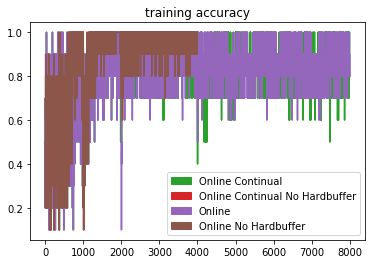

Online Continual: 90.375
Online Continual No Hardbuffer: 83.75
Online: 85.0
Online No Hardbuffer: 80.875
duration: 229.714209795


In [66]:
# ALPHA 1 HIDDEN UNITS 8 --> 10
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 10
gradient_steps = 5
seed=512
alpha=1.0
ntasks=4
start_exp=time.time()
meta_experiment()

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 1.0
quadrant 0
quadrant 1
quadrant 2
quadrant 3
step 1:  0.552947044373
step 2:  0.465765953064
step 3:  0.00892496109009

Online Continual
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance wei

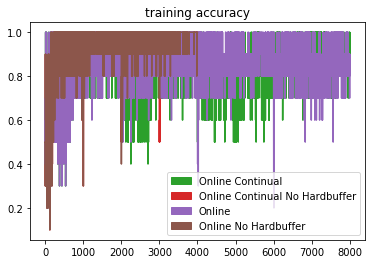

Online Continual: 80.625
Online Continual No Hardbuffer: 77.625
Online: 79.5
Online No Hardbuffer: 79.0
duration: 254.973618031


In [64]:
# ALPHA 1
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 8
gradient_steps = 5
seed=512
alpha=1.0
start_exp=time.time()
meta_experiment()

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 0.75
quadrant 0
quadrant 1
quadrant 2
quadrant 3
step 1:  0.663951873779
step 2:  0.667860031128
step 3:  0.0139470100403

Online Continual
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance wei

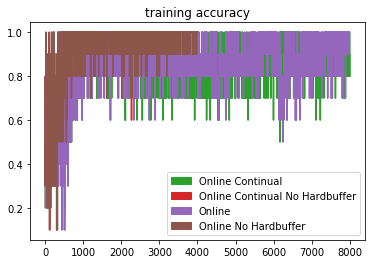

Online Continual: 96.375
Online Continual No Hardbuffer: 93.0
Online: 97.25
Online No Hardbuffer: 93.125
duration: 212.214694977


In [63]:
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 8
gradient_steps = 5
seed=512
alpha=0.75
start_exp=time.time()
meta_experiment()

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 0.5
quadrant 0
quadrant 1
quadrant 2
quadrant 3
step 1:  0.556869983673
step 2:  0.808521986008
step 3:  0.0102970600128

Online Continual
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weig

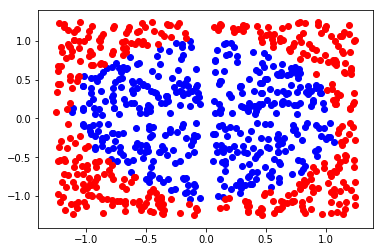

duration: 1.76641845306minutes

Online Continual No Hardbuffer
Update importance weights
Update importance weights
Update importance weights
Update importance weights


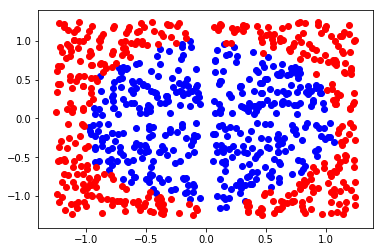

duration: 0.836305467288minutes

Online


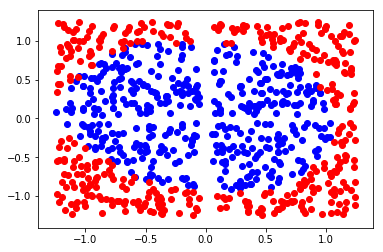

duration: 0.998314547539minutes

Online No Hardbuffer


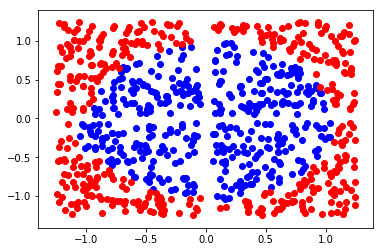

duration: 0.526767083009minutes


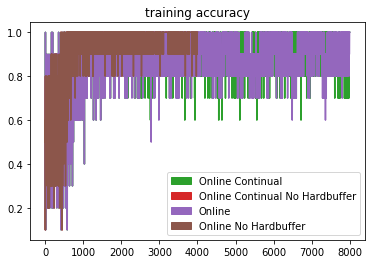

Online Continual: 93.375
Online Continual No Hardbuffer: 94.5
Online: 91.375
Online No Hardbuffer: 95.5
duration: 249.756286144


In [60]:
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 8
gradient_steps = 5
seed=512
alpha=0.5 #,0.75
start_exp=time.time()
meta_experiment()

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 0.25
quadrant 0
quadrant 1
quadrant 2
quadrant 3
step 1:  0.540539979935
step 2:  1.00458478928
step 3:  0.00939416885376

Online Continual
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance wei

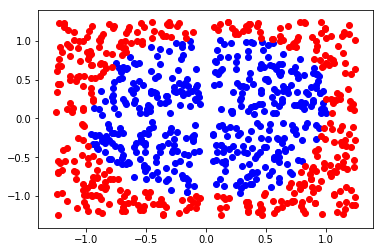

duration: 1.93008826971minutes

Online Continual No Hardbuffer
Update importance weights
Update importance weights
Update importance weights


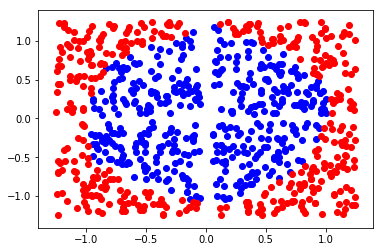

duration: 0.926664551099minutes

Online


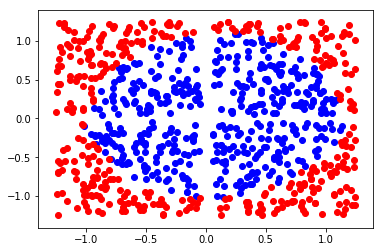

duration: 1.07212363084minutes

Online No Hardbuffer


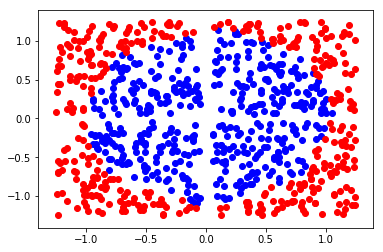

duration: 0.510560115178minutes


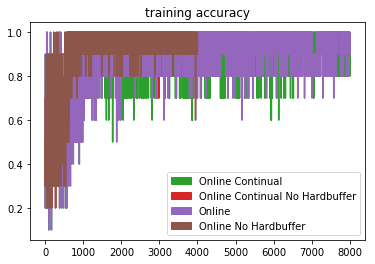

Online Continual: 95.625
Online Continual No Hardbuffer: 95.375
Online: 92.75
Online No Hardbuffer: 94.25
duration: 268.822097063


In [59]:
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 8
gradient_steps = 5
seed=512
alpha=0.25 #0.5,0.75
start_exp=time.time()
meta_experiment()

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 0.25
quadrant 0
quadrant 1
quadrant 2
quadrant 3
step 1:  0.544951200485
step 2:  1.08509397507
step 3:  0.0105769634247

Online Continual
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weig

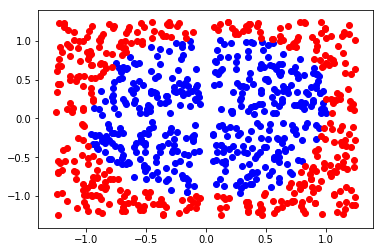

duration: 1.7605008324minutes


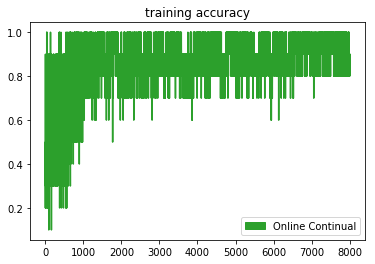

Online Continual: 95.625
duration: 107.675825119


In [58]:
tags=['Online Continual']
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 8
gradient_steps = 5
seed=512
alpha=0.25 #0.5,0.75
start_exp=time.time()
meta_experiment(tags)

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 0.25
quadrant 0
quadrant 1
quadrant 2
quadrant 3
step 1:  0.548987150192
step 2:  0.97009396553
step 3:  0.0090639591217

Online Continual No Hardbuffer
Update importance weights
Update importance weights
Update importance weights


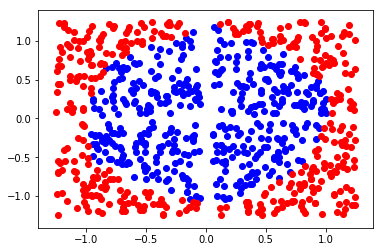

duration: 0.663563152154minutes


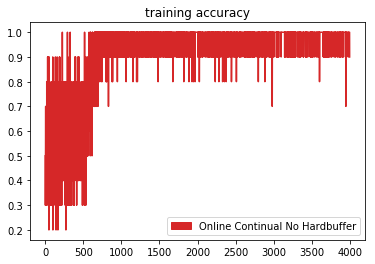

Online Continual No Hardbuffer: 95.375
duration: 41.7339081764


In [54]:
tags=['Online Continual No Hardbuffer']
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 8
gradient_steps = 5
seed=512
alpha=0.25 #0.5,0.75
start_exp=time.time()
meta_experiment(tags)

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 0.25
quadrant 0
quadrant 1
quadrant 2
quadrant 3
step 1:  0.651969909668
step 2:  0.94044303894
step 3:  0.00850796699524

Online


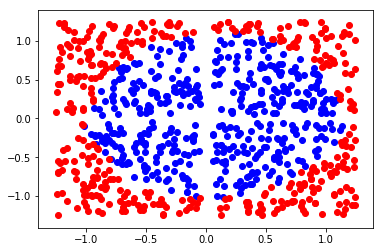

duration: 1.12257143259minutes


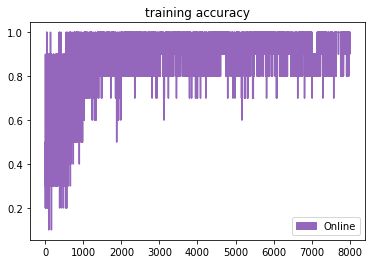

Online: 92.75
duration: 69.423197031


In [56]:
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 8
gradient_steps = 5
seed=512
alpha=0.25 #0.5,0.75
tags=['Online']
start_exp=time.time()
meta_experiment(tags)

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 0.25
quadrant 0
quadrant 1
quadrant 2
quadrant 3
step 1:  0.556836128235
step 2:  1.09945893288
step 3:  0.0166120529175

Online No Hardbuffer


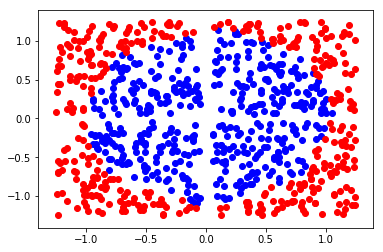

duration: 0.571270616849minutes


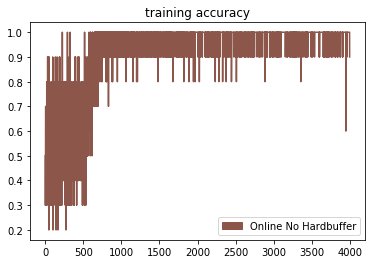

Online No Hardbuffer: 94.25
duration: 36.3032770157


In [57]:
# Optimal setting for Online No Continual and No Hardbuffer
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 8
gradient_steps = 5
seed=512
alpha=0.25 #0.5,0.75
tags=['Online No Hardbuffer']
start_exp=time.time()
meta_experiment(tags)
print "duration: "+str(time.time()-start_exp)

In [3]:

def sample_data():
    global task, train_data, test_data, inputs, labels, test_inputs
    # seed
    rn.seed(512)
    verbose=False
    # i=0
    for i in range(ntasks):
        mean=np.zeros((dim))
        mean[0]=i
        variance=var*np.identity(dim)
        task[i]=rn.multivariate_normal(mean,variance,nsamples)
        if verbose: plt.plot([j[0] for j in task[i]],[j[1] for j in task[i]],icon[i%ntasks])

    if verbose: plt.show()

    # Step 2: Split test and train data for i task
    for t in task.keys():
        train_data[t]=task[t][0:ntrain]
        test_data[t]=task[t][ntrain:]

    # Step 3: Sample correct distribution given certain alpha
    for i in range(ntasks):
        if verbose: print("Episode: ",i)
        original_task=rn.binomial(np.ones((ntrain),dtype=np.int),alpha) #1 if original task, 0 if data sampled from 1 of the others.
        inputs[i]=[]
        labels[i]=[]
        other_labels=range(ntasks)
        del other_labels[i]
#         print other_labels
        for v in original_task:
            if v:
                label=i
            else:
                label=rn.choice(other_labels)
            sample=task[label][0] # samples are popped from the distribution to avoid them to be reused.
            task[label]=task[label][1:]
            labels[i].append(label)
            inputs[i].append(sample)
            if verbose: plt.plot(sample[0],sample[1],icon[label])
        if verbose: plt.show()

    # draw some extra test data to evaluate
    for i in range(ntasks):
        test_inputs[i]=task[i][:200]
    

In [36]:
start_experiment=time.time()
results={}
alpha=0.25
results[alpha]=meta_experiment()
alpha=0.5
results[alpha]=meta_experiment()
alpha=0.75
results[alpha]=meta_experiment()
alpha=1.0
results[alpha]=meta_experiment()
print("Finished after {0:.1f}minuts".format((time.time()-start_experiment)/60))





Start experiment with alpha: 0.25

Online Continual


RuntimeError: The size of tensor a (2) must match the size of tensor b (4) at non-singleton dimension 1

In [7]:
for a in [0.25,0.5,0.75,1]:
    print a
    plt.title(sorted(tags))
    plt.bar(range(ntasks),results[a])
    plt.show()

0.25


NameError: name 'tags' is not defined

In [ ]:
print sorted(tags)
for k in results.keys():
    print k, results[k]

training data:  0


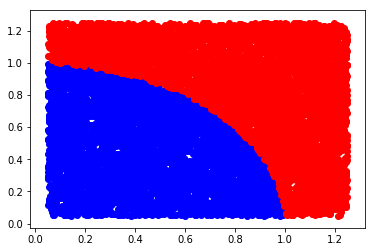

test data:  0


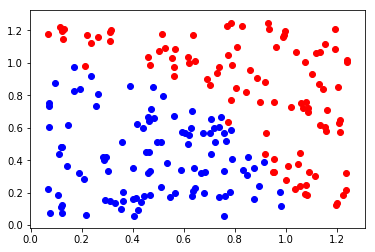

training data:  1


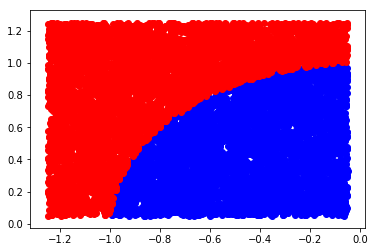

test data:  1


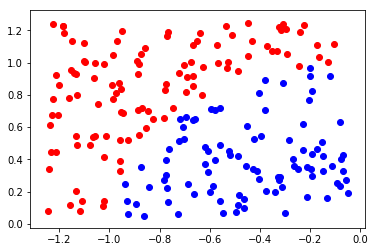

training data:  2


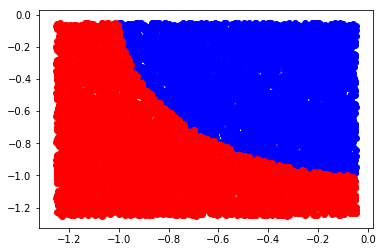

test data:  2


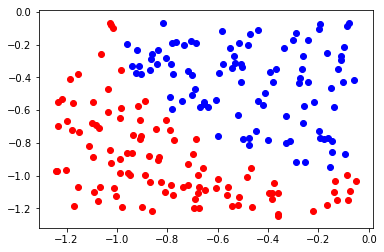

training data:  3


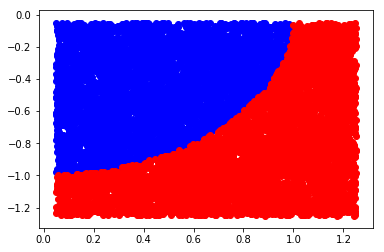

test data:  3


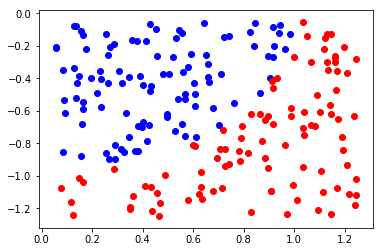

In [86]:
alpha=1
sample_data()
for q in range(4):
    print "training data: ",str(q)
    positive_points=[inputs[q][i] for i in range(len(inputs[q])) if labels[q][i]==1]
    negative_points=[inputs[q][i] for i in range(len(inputs[q])) if labels[q][i]==0]
    plt.scatter([p[0] for p in positive_points],[p[1] for p in positive_points],color='blue')
    plt.scatter([p[0] for p in negative_points],[p[1] for p in negative_points],color='red')
    plt.show()

    print "test data: ",str(q)
    positive_points=[test_inputs[q][i] for i in range(len(test_inputs[q])) if test_labels[q][i]==1]
    negative_points=[test_inputs[q][i] for i in range(len(test_inputs[q])) if test_labels[q][i]==0]
    plt.scatter([p[0] for p in positive_points],[p[1] for p in positive_points],color='blue')
    plt.scatter([p[0] for p in negative_points],[p[1] for p in negative_points],color='red')
    plt.show()